# Predict species-wise volumes via proxy

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

## Step 1: predict species-wise percentages

In [4]:
def tree_pcts(row):
    return [row.v_ma/row.v, row.v_ku/row.v, row.v_lp/row.v]

In [5]:
preprocessor.train_val_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.train_val_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')
preprocessor.test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.test_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

Extract image features 

In [6]:
rel_trainval_tb, rel_test_tb = preprocessor.preprocess_image(target_col=['rel_v_ma', 'rel_v_ku', 'rel_v_lp'], path=data_path/'AV_tif',
                                                             mask_plot=False,
                                                             #min_h=1.5,
                                                             normalize=True,
                                                             log_y=False)

100%|██████████| 225/225 [00:01<00:00, 222.82it/s]


In [8]:
rel_dls = rel_trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

In [10]:
learn = tabular_learner(rel_dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0,1)#trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 40'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 40              80         True      
________________________________________________________________
BatchNorm1d          64 x 40              80         True      
________________________________________________________________
Linear               64 x 200             8,000      True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.159854,0.160553,0.400691,120.207085,0.159851,47.955067,0.375188,-0.156302,00:00
1,0.152008,0.144635,0.380310,114.092682,0.148852,44.655598,0.355510,-0.041662,00:00
2,0.141214,0.119834,0.346171,103.851143,0.130905,39.271366,0.322069,0.136954,00:00
3,0.126973,0.091754,0.302909,90.872589,0.105589,31.676662,0.278048,0.339189,00:00
4,0.109837,0.062879,0.250757,75.227013,0.072299,21.689665,0.222632,0.547145,00:00
5,0.092332,0.042480,0.206108,61.832237,0.041925,12.577609,0.169831,0.694057,00:00
6,0.078044,0.033725,0.183643,55.092693,0.021561,6.468298,0.141350,0.757116,00:00
7,0.067310,0.031081,0.176299,52.889530,0.013162,3.948612,0.130267,0.776153,00:00
8,0.059579,0.030436,0.174460,52.337803,0.006550,1.965066,0.126968,0.780799,00:00
9,0.053897,0.029859,0.172798,51.839222,0.005586,1.675942,0.123581,0.784956,00:00


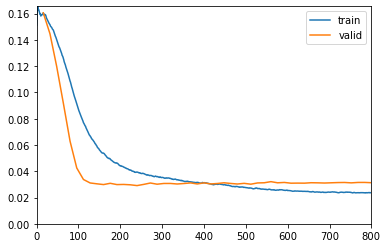

In [11]:
learn.fit_one_cycle(50, max_lr=1e-2, cbs=ShowGraphCallback())

In [15]:
reg_interp = RegressionInterpretation.from_learner(learn, dl=learn.dls[1])

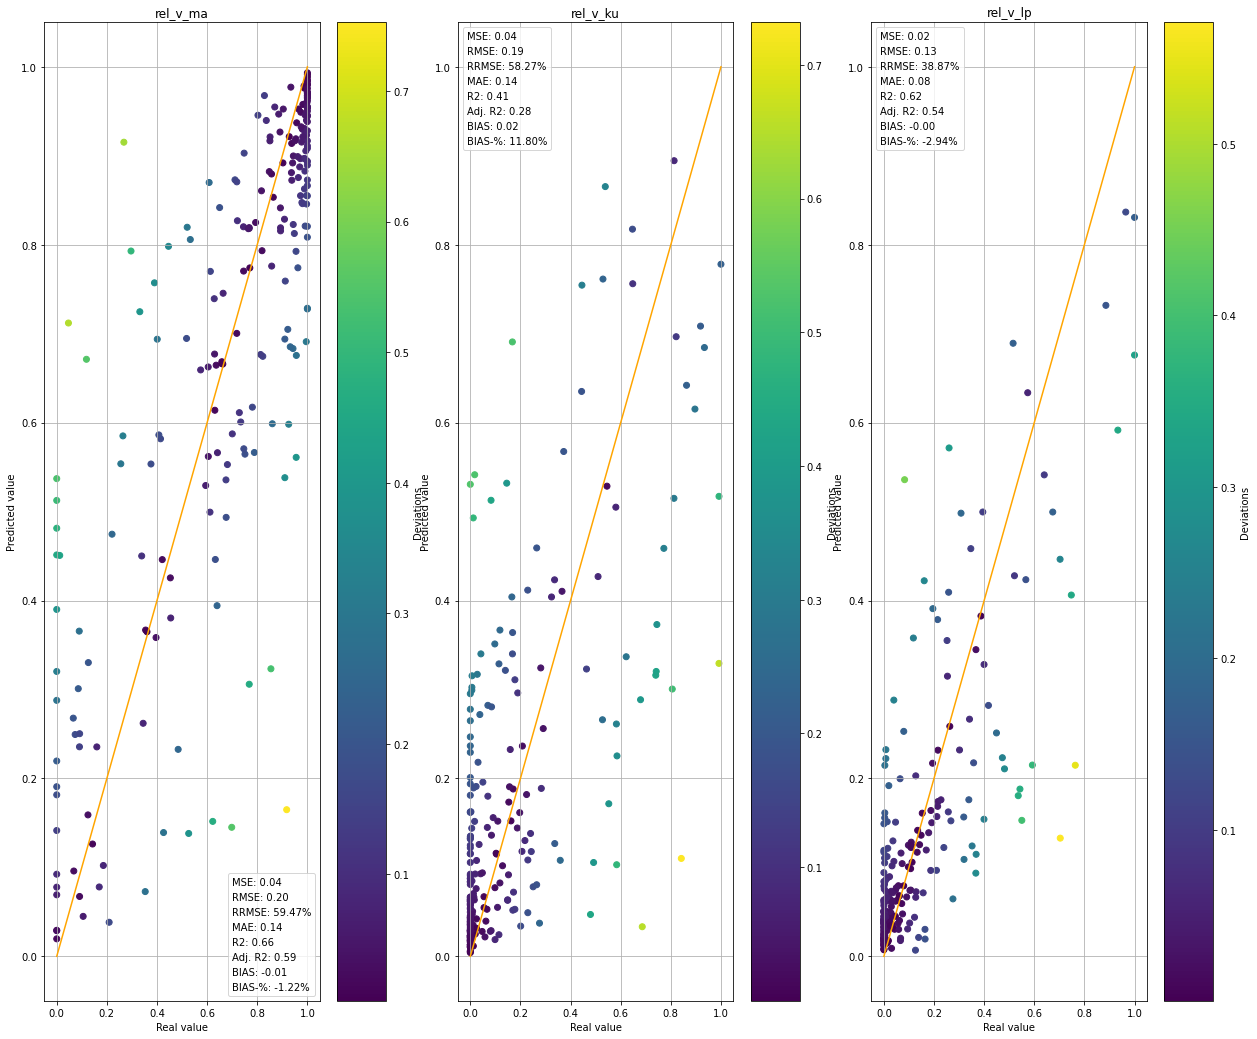

In [16]:
reg_interp.plot_results(log_y=False)
plt.show()

In [18]:
test_dls = rel_test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [19]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

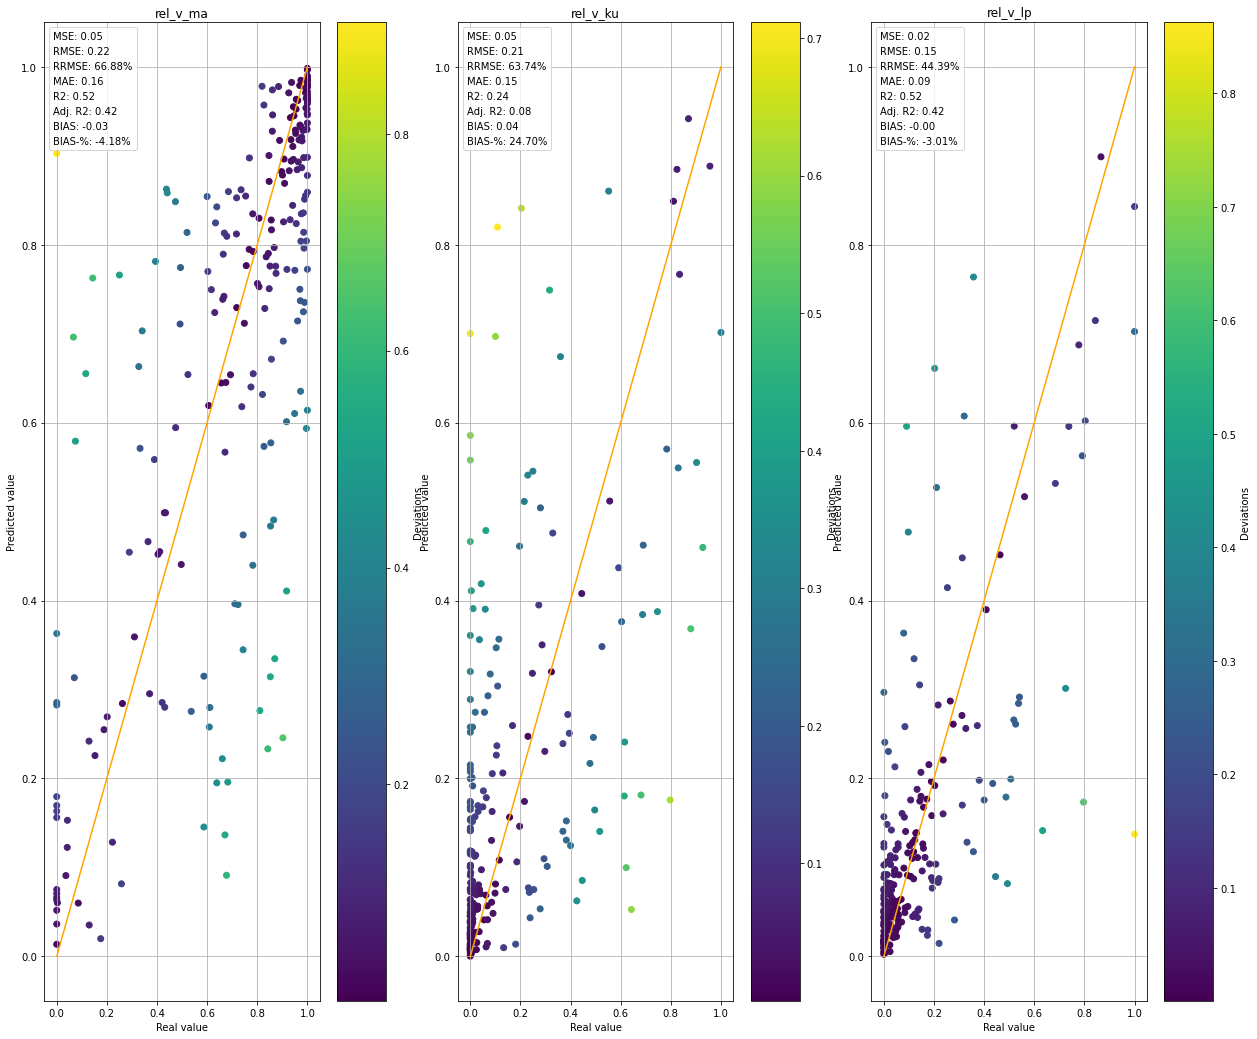

In [20]:
test_interp.plot_results(log_y=False)
plt.show()

In [36]:
rel_preds, rel_true = learn.get_preds(dl=test_dls)

## Predict overall volume from lidar features

In [22]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col=['v'], path=data_path/'AV_las',
                                                     mask_plot=True,
                                                     min_h=1.5,
                                                     normalize=True,
                                                     log_y=False)

100%|██████████| 225/225 [00:09<00:00, 24.03it/s]


In [23]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

In [24]:
v_learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0,trainval_tb.train.y.max()*1.1)
                       )


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,93240.492188,94786.843750,307.874725,204.203445,293.961121,194.974991,294.724976,-9.415220,00:00
1,82484.914062,66745.312500,258.351135,171.356018,243.719482,161.651321,245.960144,-6.334004,00:00
2,68671.140625,38469.171875,196.135590,130.090454,175.429794,116.356956,181.351471,-3.227009,00:00
3,53085.210938,18450.705078,135.833374,90.093925,102.846527,68.214806,120.551956,-1.027371,00:00
4,38754.101562,7672.947754,87.595360,58.099194,50.163536,33.271866,72.885414,0.156893,00:00
5,27633.982422,3549.511475,59.577778,39.516033,17.193550,11.403931,45.715736,0.609978,00:00
6,19897.617188,2658.266602,51.558380,34.197021,7.410127,4.914900,35.763390,0.707909,00:00
7,14594.741211,1892.001099,43.497139,28.850258,-1.756308,-1.164903,30.117090,0.792106,00:00
8,10885.674805,1737.899536,41.688126,27.650398,4.941613,3.277613,28.843122,0.809039,00:00
9,8205.127930,1948.197998,44.138397,29.275585,-4.492333,-2.979620,30.874273,0.785931,00:00


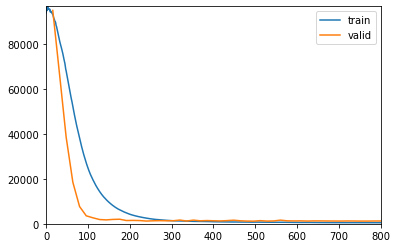

In [25]:
v_learn.fit_one_cycle(50, max_lr=1e-2, cbs=ShowGraphCallback())

In [29]:
v_reg_interp = RegressionInterpretation.from_learner(v_learn, dl=v_learn.dls[1])

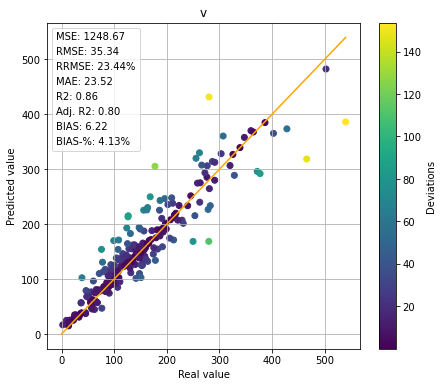

In [30]:
v_reg_interp.plot_results(log_y=False)
plt.show()

In [31]:
v_test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [40]:
v_preds, v_true = v_learn.get_preds(dl=v_test_dls)

# Combine predictions

In [88]:
from fastai.vision.all import *
import matplotlib.patches as mpl_patches


In [56]:
pred_v_ma = v_preds[:,0] * rel_preds[:,0]

In [92]:
def plot_results(preds, targs, title='Regression results', **kwargs) -> plt.Axes:
    "Plot result image for regression tasks, code still need prettifying"
    axs = get_grid(1, figsize=((6+1)*1, (6)*1)) # if we have multitarget
    if len(targs.shape) == 1: targs = targs[:,None]
    for i, a in enumerate(axs):
        im = a.scatter(targs, preds, c=torch.abs(targs-preds))
        a.set_xlabel('Real value')
        a.set_ylabel('Predicted value')
        a.set_title('Results')
        a.grid()
        x = np.linspace(0, max(preds.max(),targs.max()))
        a.plot(x, x, color='orange')
        cbar = plt.colorbar(im, ax=a)
        cbar.ax.set_ylabel('Deviations', rotation=90)

        labels = []
        res_mse = mse(targs, preds)
        labels.append(f'MSE: {res_mse:.2f}')

        res_rmse = rmse(targs, preds) 
        labels.append(f'RMSE: {res_rmse:.2f}'
                     )
        res_rrmse = res_rmse / targs.mean() * 100
        labels.append(f'RRMSE: {res_rrmse:.2f}%')

        res_mae = mae(targs, preds)
        labels.append(f'MAE: {res_mae:.2f}')

        r2 = R2Score()(preds, targs)
        labels.append(f'R2: {r2:.2f}')

        res_bias = bias(preds, targs)
        labels.append(f'BIAS: {res_bias:.2f}')

        res_pct_bias = bias_pct(preds, targs)
        labels.append(f'BIAS-%: {res_pct_bias:.2f}%')

        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                   lw=0, alpha=0)] * len(labels)
        a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
    return axs

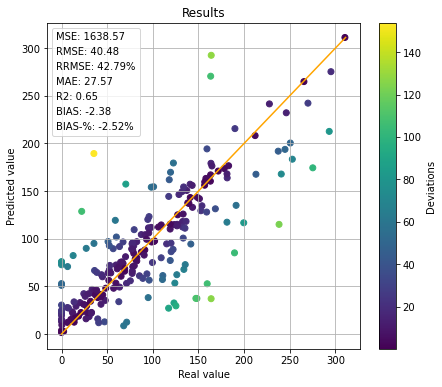

In [101]:
plot_results(pred_v_ma[:,None], Tensor(preprocessor.test_df.v_ma.values[:,None]))
plt.show()

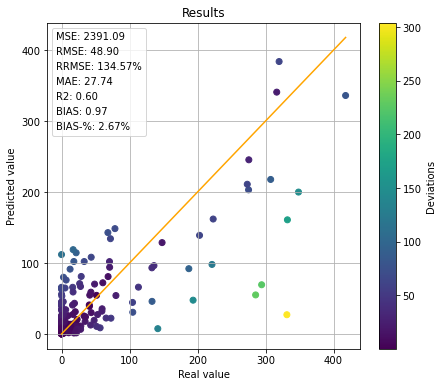

In [102]:
pred_v_ku = v_preds[:,0] * rel_preds[:,1]
plot_results(pred_v_ku[:,None], Tensor(preprocessor.test_df.v_ku.values[:,None]))
plt.show()

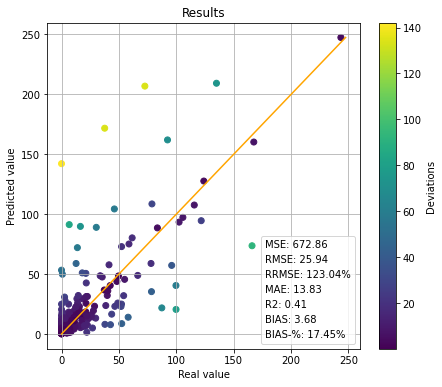

In [103]:
pred_v_lp = v_preds[:,0] * rel_preds[:,2]
plot_results(pred_v_lp[:,None], Tensor(preprocessor.test_df.v_lp.values[:,None]))
plt.show()